In [6]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.stats import binom, gaussian_kde
from sbi.analysis.plot import _update, prepare_for_plot,_arrange_plots, probs2contours, get_diag_func
import matplotlib as mpl
from logging import warn


In [7]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()

In [8]:
x_o = torch.ones(1, 20)  # simulator output was 20-dimensional
posterior.set_default_x(x_o)

### List of current options
samples: Samples used to build the histogram.

points: List of additional points to scatter.

limits: Array containing the plot xlim for each parameter dimension. If None,
    just use the min and max of the passed samples

subset: List containing the dimensions to plot. E.g. subset=[1,3] will plot
    plot only the 1st and 3rd dimension but will discard the 0th and 2nd (and,
    if they exist, the 4th, 5th and so on).

offdiag: Plotting style for upper diagonal, {hist, scatter, contour, cond,
    None}.

upper: deprecated, use offdiag instead.

diag: Plotting style for diagonal, {hist, cond, None}.

figsize: Size of the entire figure.

labels: List of strings specifying the names of the parameters.

ticks: Position of the ticks.

fig: matplotlib figure to plot on.

axes: matplotlib axes corresponding to fig.

**kwargs: Additional arguments to adjust the plot, e.g., `samples_colors`,
    `points_colors` and many more, see the source code in `_get_default_opts()`
    in `sbi.analysis.plot` for details.

In [9]:
# Current get_default_opts() function

def _get_default_opts():
    """Return default values for plotting specs."""
    return {
        # 'lower': None,     # hist/scatter/None  # TODO: implement
        # title and legend
        "title": None,
        "legend": False,
        "legend_kwargs": {},
        # labels
        "points_labels": [f"points_{idx}" for idx in range(10)],  # for points
        "samples_labels": [f"samples_{idx}" for idx in range(10)],  # for samples
        # colors: take even colors for samples, odd colors for points
        "samples_colors": plt.rcParams["axes.prop_cycle"].by_key()["color"][0::2],
        "points_colors": plt.rcParams["axes.prop_cycle"].by_key()["color"][1::2],
        # ticks
        "ticks": [],
        "tickformatter": mpl.ticker.FormatStrFormatter("%g"),  # type: ignore
        "tick_labels": None,
        # options for hist
        "hist_diag": {
            "alpha": 1.0,
            "bins": 50,
            "density": False,
            "histtype": "step",
        },
        "hist_offdiag": {
            # 'edgecolor': 'none',
            # 'linewidth': 0.0,
            "bins": 50,
        },
        # options for kde
        "kde_diag": {"bw_method": "scott", "bins": 50, "color": "black"},
        "kde_offdiag": {"bw_method": "scott", "bins": 50},
        # options for contour
        "contour_offdiag": {"levels": [0.68], "percentile": True},
        # options for scatter
        "scatter_offdiag": {
            "alpha": 0.5,
            "edgecolor": "none",
            "rasterized": False,
        },
        "scatter_diag": {},
        # options for plot
        "plot_offdiag": {},
        # formatting points (scale, markers)
        "points_diag": {},
        "points_offdiag": {
            "marker": ".",
            "markersize": 10,
        },
        # other options
        "fig_bg_colors": {"offdiag": None, "diag": None, "lower": None},
        "fig_subplots_adjust": {
            "top": 0.9,
        },
        "subplots": {},
        "despine": {
            "offset": 5,
        },
        "title_format": {"fontsize": 16},
    }

In [36]:
def pairplot(
    samples: Union[List[np.ndarray], List[torch.Tensor], np.ndarray, torch.Tensor],
    points: Optional[
        Union[List[np.ndarray], List[torch.Tensor], np.ndarray, torch.Tensor]
    ] = None,
    limits: Optional[Union[List, torch.Tensor]] = None,
    subset: Optional[List[int]] = None,
    offdiag: Optional[Union[List[str], str]] = "hist",
    diag: Optional[Union[List[str], str]] = "hist",
    figsize: Tuple = (10, 10),
    labels: Optional[List[str]] = None,
    ticks: Optional[Union[List, torch.Tensor]] = None,
    upper: Optional[str] = None,
    fig=None,
    axes=None,
    **kwargs,
):
    """
    Plot samples in a 2D grid showing marginals and pairwise marginals.

    Each of the diagonal plots can be interpreted as a 1D-marginal of the distribution
    that the samples were drawn from. Each upper-diagonal plot can be interpreted as a
    2D-marginal of the distribution.

    Args:
        samples: Samples used to build the histogram.
        points: List of additional points to scatter.
        limits: Array containing the plot xlim for each parameter dimension. If None,
            just use the min and max of the passed samples
        subset: List containing the dimensions to plot. E.g. subset=[1,3] will plot
            plot only the 1st and 3rd dimension but will discard the 0th and 2nd (and,
            if they exist, the 4th, 5th and so on).
        offdiag: Plotting style for upper diagonal, {hist, scatter, contour, cond,
            None}.
        upper: deprecated, use offdiag instead.
        diag: Plotting style for diagonal, {hist, cond, None}.
        figsize: Size of the entire figure.
        labels: List of strings specifying the names of the parameters.
        ticks: Position of the ticks.
        fig: matplotlib figure to plot on.
        axes: matplotlib axes corresponding to fig.
        **kwargs: Additional arguments to adjust the plot, e.g., `samples_colors`,
            `points_colors` and many more, see the source code in `_get_default_opts()`
            in `sbi.analysis.plot` for details.

    Returns: figure and axis of posterior distribution plot
    """

    # TODO: add color map support
    # TODO: automatically determine good bin sizes for histograms
    # TODO: add legend (if legend is True)

    opts = _get_default_opts()
    # update the defaults dictionary by the current values of the variables (passed by
    # the user)

    opts = _update(opts, locals())
    opts = _update(opts, kwargs)

    samples, dim, limits = prepare_for_plot(samples, limits)

    # checks.
    if opts["legend"]:
        assert len(opts["samples_labels"]) >= len(
            samples
        ), "Provide at least as many labels as samples."
    if opts["upper"] is not None:
        warn("upper is deprecated, use offdiag instead.", stacklevel=2)
        opts["offdiag"] = opts["upper"]

    # Prepare diag/upper/lower
    if not isinstance(opts["diag"], list):
        opts["diag"] = [opts["diag"] for _ in range(len(samples))]
    if not isinstance(opts["offdiag"], list):
        opts["offdiag"] = [opts["offdiag"] for _ in range(len(samples))]
    # if type(opts['lower']) is not list:
    #    opts['lower'] = [opts['lower'] for _ in range(len(samples))]
    opts["lower"] = None

    diag_func = get_diag_func(samples, limits, opts, **kwargs)

    offdiag_func = get_offdiag_func(samples, limits, opts, **kwargs)

    return _arrange_plots(
        diag_func, offdiag_func, dim, limits, points, opts, fig=fig, axes=axes
    )

def get_offdiag_func(samples, limits, opts, **kwargs):
    def offdiag_func(row, col, **kwargs):
        if len(samples) > 0:
            for n, v in enumerate(samples):
                if opts["offdiag"][n] == "hist" or opts["offdiag"][n] == "hist2d":
                    hist, xedges, yedges = np.histogram2d(
                        v[:, col],
                        v[:, row],
                        range=[
                            [limits[col][0], limits[col][1]],
                            [limits[row][0], limits[row][1]],
                        ],
                        **opts["hist_offdiag"],
                    )
                    plt.imshow(
                        hist.T,
                        origin="lower",
                        extent=(
                            xedges[0],
                            xedges[-1],
                            yedges[0],
                            yedges[-1],
                        ),
                        aspect="auto",
                    )

                elif opts["offdiag"][n] in [
                    "kde",
                    "kde2d",
                    "contour",
                    "contourf",
                ]:
                    density = gaussian_kde(
                        v[:, [col, row]].T,
                        bw_method=opts["kde_offdiag"]["bw_method"],
                    )
                    X, Y = np.meshgrid(
                        np.linspace(
                            limits[col][0],
                            limits[col][1],
                            opts["kde_offdiag"]["bins"],
                        ),
                        np.linspace(
                            limits[row][0],
                            limits[row][1],
                            opts["kde_offdiag"]["bins"],
                        ),
                    )
                    positions = np.vstack([X.ravel(), Y.ravel()])
                    Z = np.reshape(density(positions).T, X.shape)

                    if opts["offdiag"][n] == "kde" or opts["offdiag"][n] == "kde2d":
                        plt.imshow(
                            Z,
                            extent=(
                                limits[col][0],
                                limits[col][1],
                                limits[row][0],
                                limits[row][1],
                            ),
                            origin="lower",
                            aspect="auto",
                        )
                    elif opts["offdiag"][n] == "contour":
                        if opts["contour_offdiag"]["percentile"]:
                            Z = probs2contours(Z, opts["contour_offdiag"]["levels"])
                        else:
                            Z = (Z - Z.min()) / (Z.max() - Z.min())
                        plt.contour(
                            X,
                            Y,
                            Z,
                            origin="lower",
                            extent=[
                                limits[col][0],
                                limits[col][1],
                                limits[row][0],
                                limits[row][1],
                            ],
                            colors=opts["samples_colors"][n],
                            levels=opts["contour_offdiag"]["levels"],
                        )
                    else:
                        pass
                elif opts["offdiag"][n] == "scatter":
                    plt.scatter(
                        v[:, col],
                        v[:, row],
                        color=opts["samples_colors"][n],
                        **opts["scatter_offdiag"],
                    )
                elif opts["offdiag"][n] == "plot":
                    plt.plot(
                        v[:, col],
                        v[:, row],
                        color=opts["samples_colors"][n],
                        **opts["plot_offdiag"],
                    )
                else:
                    pass
    return offdiag_func

In [37]:
upper_diag = "scatter" 
diag_kwargs = {}
offdiag_kwargs = {}
fig_kwargs = {}


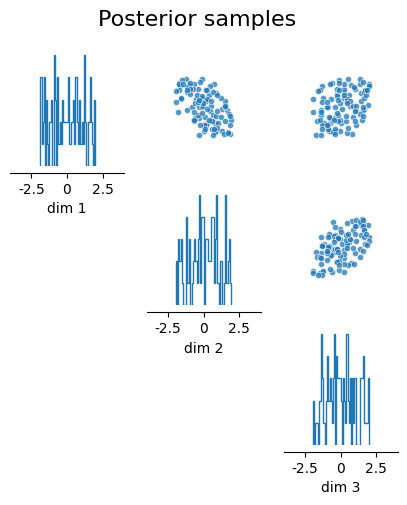

In [38]:
posterior_samples = posterior.sample((100,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-4.0, 4.0]] * 3),
    offdiag=["scatter"],
    diag=["hist"],
    figsize=(5, 5),
    title = "Posterior samples",
    color = 'tab:blue',
    scatter_offdiag ={"alpha":.75,
                      "edgecolor":"white",
                      "s":20,
                      "linewidths":.5},
)

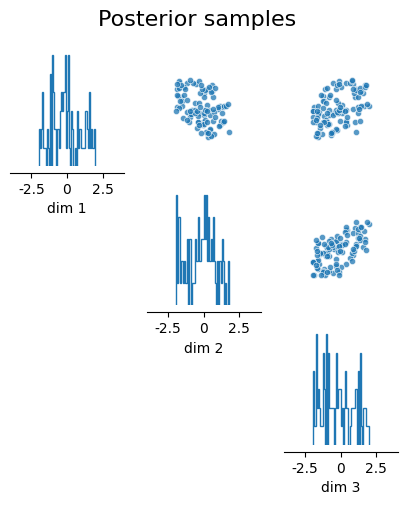

In [22]:
posterior_samples = posterior.sample((100,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-4.0, 4.0]] * 3),
    offdiag=["scatter"],
    diag=["hist"],
    figsize=(5, 5),
    title = "Posterior samples",
    color = 'tab:blue',
    scatter_offdiag ={"alpha":.75,
                      "edgecolor":"white",
                      "s":20,
                      "linewidths":.5},
)

In [ ]:
posterior_samples = posterior.sample((1000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    offdiag=["hist"],
    diag=["hist"],
    figsize=(5, 5),
)

In [ ]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    offdiag=["contour"],
    diag=["kde"],
    figsize=(5, 5),
)

In [ ]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)

In [ ]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.0, 2.0]] * 3),
    offdiag=["kde"],
    diag=["kde"],
    figsize=(5, 5),
)